In [1]:
import shutil
import logging
import warnings
import pandas as pd
from sklearn.metrics import accuracy_score
from ageas import Panel
from ageas.tool import Multimodal_Corpus, make_fake_adata
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import scanpy as sc

/data/jiangjunyao/miniconda3/envs/ageas/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata = sc.read_h5ad('/data/jiangjunyao/fa_result/CS8_human_spatial/epi_ps_ecto.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 3394 × 25958
    obs: 'nCount_RNA', 'nFeature_RNA', 'x', 'y', 'clusters', 'Batch', 'celltype', 'RNA_snn_res.1', 'seurat_clusters'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_spatial', 'X_umap'

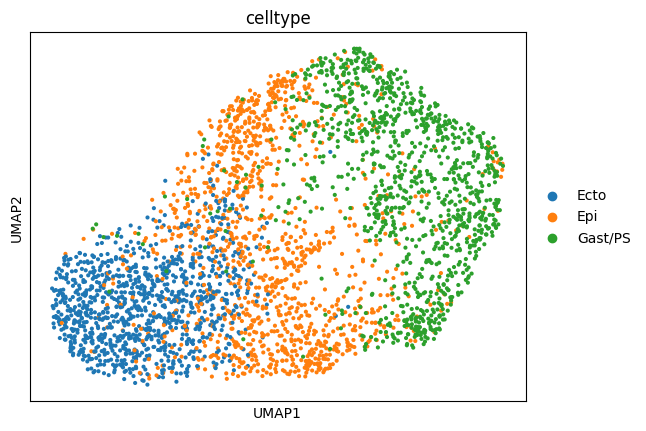

In [4]:
sc.pl.umap(adata,color=['celltype'])

In [5]:
adata.obs.celltype.value_counts()

celltype
Epi        1238
Gast/PS    1091
Ecto       1065
Name: count, dtype: int64

In [6]:
sc.pp.filter_genes(adata,min_cells=5)
adata

AnnData object with n_obs × n_vars = 3394 × 17694
    obs: 'nCount_RNA', 'nFeature_RNA', 'x', 'y', 'clusters', 'Batch', 'celltype', 'RNA_snn_res.1', 'seurat_clusters'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'n_cells'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_spatial', 'X_umap'

In [7]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True,flavor='seurat_v3')

/data/jiangjunyao/miniconda3/envs/ageas/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [8]:
adata.X.max()

5.486391575831441

In [9]:
adata_test = adata[adata.obs['celltype']=='Epi']
adata_train = adata[adata.obs['celltype'].isin(['Gast/PS','Ecto'])]
adata_train.obs.celltype.value_counts()

celltype
Gast/PS    1091
Ecto       1065
Name: count, dtype: int64

# Prepare training and testing dataset

In [10]:
train = Multimodal_Corpus(
    adata=adata_train,
    label_key = 'celltype',
    backed=False
)
test = Multimodal_Corpus(
    adata=adata_test,
    label_key = 'celltype',
    backed=False
)
panel = Panel(
    config_folder = '/data/jiangjunyao/fa_result/config_tunning/config_larry_v5',
    verbose = True,
)

## Transfer learning

In [11]:
deck = panel.n_kfold_selection(
    accelerator = 'cuda',
    query_dataset = train,
    kfold_selection_list = [2],
    valid_fraction = 0.1,

    monitor_type = 'max',
    monitor_metric = 'test.accuracy',
    min_requirement = 0.5,
    stratified_kfold_test = True,
    verbose = True,
)
# Remove the caches
shutil.rmtree('cache')

Deployment: 1 / 1
K-Fold cross validating: 2
Num of units: 22
Fold 1 / 2
	Type:logreg, Unit:logreg_C_1


/data/jiangjunyao/miniconda3/envs/ageas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



		Validation: {'vali.CEL': tensor(0.3304), 'vali.accuracy': tensor(0.9907), 'vali.f1': tensor(0.9906), 'vali.auroc': tensor(0.9976)}
		Test: {'test.CEL': tensor(0.3384), 'test.accuracy': tensor(0.9787), 'test.f1': tensor(0.9787), 'test.auroc': tensor(0.9988)}

	Type:logreg, Unit:logreg_C_01


/data/jiangjunyao/miniconda3/envs/ageas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



		Validation: {'vali.CEL': tensor(0.3469), 'vali.accuracy': tensor(0.9907), 'vali.f1': tensor(0.9906), 'vali.auroc': tensor(0.9993)}
		Test: {'test.CEL': tensor(0.3545), 'test.accuracy': tensor(0.9814), 'test.f1': tensor(0.9814), 'test.auroc': tensor(0.9985)}

	Type:logreg, Unit:logreg_C_10


/data/jiangjunyao/miniconda3/envs/ageas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



		Validation: {'vali.CEL': tensor(0.3284), 'vali.accuracy': tensor(0.9907), 'vali.f1': tensor(0.9906), 'vali.auroc': tensor(0.9979)}
		Test: {'test.CEL': tensor(0.3376), 'test.accuracy': tensor(0.9787), 'test.f1': tensor(0.9787), 'test.auroc': tensor(0.9986)}

	Type:svc, Unit:svc_C_1

		Validation: {'vali.CEL': tensor(0.3329), 'vali.accuracy': tensor(0.9907), 'vali.f1': tensor(0.9906), 'vali.auroc': tensor(0.9986)}
		Test: {'test.CEL': tensor(0.3369), 'test.accuracy': tensor(0.9805), 'test.f1': tensor(0.9805), 'test.auroc': tensor(0.9981)}

	Type:svc, Unit:svc_C_10

		Validation: {'vali.CEL': tensor(0.3345), 'vali.accuracy': tensor(0.9907), 'vali.f1': tensor(0.9906), 'vali.auroc': tensor(0.9986)}
		Test: {'test.CEL': tensor(0.3385), 'test.accuracy': tensor(0.9805), 'test.f1': tensor(0.9805), 'test.auroc': tensor(0.9981)}

	Type:svc, Unit:svc_C_01


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



		Validation: {'vali.CEL': tensor(0.3343), 'vali.accuracy': tensor(0.9907), 'vali.f1': tensor(0.9906), 'vali.auroc': tensor(0.9986)}
		Test: {'test.CEL': tensor(0.3382), 'test.accuracy': tensor(0.9805), 'test.f1': tensor(0.9805), 'test.auroc': tensor(0.9981)}

	Type:rnn, Unit:gru_7


You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | embedder  | Sequential         | 64.1 K | train
1 | dropout   | Dropout            | 0      | train
2 | fc        | Linear             | 10     | train
3 | criterion | CrossEntropyLoss   | 0      | train
4 | accuracy  | MulticlassAccuracy | 0      | train
5 | f1        | MulticlassF1Score  | 0      | train
6 | auroc     | MulticlassAUROC    | 0      | train
7 | block1    | Sequential         | 3.9 K  | train
8 | block2    | Sequential         | 420    | train
-------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL            0.6588075757026672
      test.accuracy         0.9063079953193665
       test.auroc           0.9534265398979187
         test.f1            0.9021095037460327
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.6743), 'vali.CEL': tensor(0.6560), 'vali.accuracy': tensor(0.9259), 'vali.f1': tensor(0.9193), 'vali.auroc': tensor(0.9641)}
		Test: {'test.CEL': 0.6588075757026672, 'test.accuracy': 0.9063079953193665, 'test.f1': 0.9021095037460327, 'test.auroc': 0.9534265398979187}

	Type:rnn, Unit:rnn_latentdim_32_block_dims_[16, 8]_block_num_[2, 2]_block_num_layer2_lr0001_droupout_02

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | embedder  | Sequential         | 64.1 K | train
1 | dropout   | Dropout            | 0      | train
2 | fc        | Linear             | 18     | train
3 | criterion | CrossEntropyLoss   | 0      | train
4 | accuracy  | MulticlassAccuracy | 0      | train
5 | f1        | MulticlassF1Score  | 0      | train
6 | auroc     | MulticlassAUROC    | 0      | train
7 | block1    | Sequential         | 8.3 K  | train
8 | block2    | Sequential         | 2.2 K  | train
---------------------------------------------------------
74.6 K    Trainable params
0         Non-trainable params
74.6 K    Total params
0.298     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: Fal

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL            0.08832293003797531
      test.accuracy         0.9823747873306274
       test.auroc           0.9969262480735779
         test.f1            0.9765104055404663
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.0003), 'vali.CEL': tensor(0.0578), 'vali.accuracy': tensor(0.9907), 'vali.f1': tensor(0.9906), 'vali.auroc': tensor(1.)}
		Test: {'test.CEL': 0.08832293003797531, 'test.accuracy': 0.9823747873306274, 'test.f1': 0.9765104055404663, 'test.auroc': 0.9969262480735779}

	Type:rnn, Unit:gru_2


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | embedder  | Sequential         | 128 K  | train
1 | dropout   | Dropout            | 0      | train
2 | fc        | Linear             | 34     | train
3 | criterion | CrossEntropyLoss   | 0      | train
4 | accuracy  | MulticlassAccuracy | 0      | train
5 | f1        | MulticlassF1Score  | 0      | train
6 | auroc     | MulticlassAUROC    | 0      | train
7 | block1    | Sequential         | 5.9 K  | train
---------------------------------------------------------
134 K     Trainable params
0         Non-trainable params
134 K     Total params
0.537     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL            0.6895387768745422
      test.accuracy          0.502782940864563
       test.auroc           0.8443224430084229
         test.f1            0.34906792640686035
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.7184), 'vali.CEL': tensor(0.7436), 'vali.accuracy': tensor(0.4537), 'vali.f1': tensor(0.3261), 'vali.auroc': tensor(0.7323)}
		Test: {'test.CEL': 0.6895387768745422, 'test.accuracy': 0.502782940864563, 'test.f1': 0.34906792640686035, 'test.auroc': 0.8443224430084229}

	Type:rnn, Unit:gru_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | embedder  | Sequential         | 256 K  | train
1 | dropout   | Dropout            | 0      | train
2 | fc        | Linear             | 34     | train
3 | criterion | CrossEntropyLoss   | 0      | train
4 | accuracy  | MulticlassAccuracy | 0      | train
5 | f1        | MulticlassF1Score  | 0      | train
6 | auroc     | MulticlassAUROC    | 0      | train
7 | block1    | Sequential         | 10.0 K | train
---------------------------------------------------------
266 K     Trainable params
0         Non-trainable params
266 K     Total params
1.066     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL            0.5540893077850342
      test.accuracy         0.6512059569358826
       test.auroc           0.9277567863464355
         test.f1            0.6044631004333496
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(1.9062), 'vali.CEL': tensor(0.5289), 'vali.accuracy': tensor(0.6852), 'vali.f1': tensor(0.6225), 'vali.auroc': tensor(0.9267)}
		Test: {'test.CEL': 0.5540893077850342, 'test.accuracy': 0.6512059569358826, 'test.f1': 0.6044631004333496, 'test.auroc': 0.9277567863464355}

	Type:rnn, Unit:rnn_latentdim_32_block_dims_[16, 8]_block_num_[2, 2]_block_num_layer1_lr001_droupout_01


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | embedder  | Sequential         | 64.1 K | train
1 | dropout   | Dropout            | 0      | train
2 | fc        | Linear             | 18     | train
3 | criterion | CrossEntropyLoss   | 0      | train
4 | accuracy  | MulticlassAccuracy | 0      | train
5 | f1        | MulticlassF1Score  | 0      | train
6 | auroc     | MulticlassAUROC    | 0      | train
7 | block1    | Sequential         | 4.9 K  | train
8 | block2    | Sequential         | 1.3 K  | train
---------------------------------------------------------
70.4 K    Trainable params
0         Non-trainable params
70.4 K    Total params
0.282     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: Fal

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL            0.07104276120662689
      test.accuracy         0.9805194735527039
       test.auroc           0.9985827207565308
         test.f1             0.976689338684082
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.0002), 'vali.CEL': tensor(0.0205), 'vali.accuracy': tensor(0.9907), 'vali.f1': tensor(0.9906), 'vali.auroc': tensor(1.)}
		Test: {'test.CEL': 0.07104276120662689, 'test.accuracy': 0.9805194735527039, 'test.f1': 0.976689338684082, 'test.auroc': 0.9985827207565308}

	Type:mlp, Unit:mlp_latentdim_64_block_dims_[128, 32]_block_num_[3, 3]_lr00001_droupout_02


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | embedder  | Sequential         | 128 K  | train
1 | dropout   | Dropout            | 0      | train
2 | fc        | Linear             | 66     | train
3 | criterion | CrossEntropyLoss   | 0      | train
4 | accuracy  | MulticlassAccuracy | 0      | train
5 | f1        | MulticlassF1Score  | 0      | train
6 | auroc     | MulticlassAUROC    | 0      | train
7 | block1    | Sequential         | 61.0 K | train
8 | block2    | Sequential         | 19.5 K | train
---------------------------------------------------------
208 K     Trainable params
0         Non-trainable params
208 K     Total params
0.835     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: Fal

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL            0.6932415962219238
      test.accuracy          0.505565881729126
       test.auroc           0.9899367690086365
         test.f1            0.32833659648895264
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.6913), 'vali.CEL': tensor(0.6903), 'vali.accuracy': tensor(0.5556), 'vali.f1': tensor(0.3498), 'vali.auroc': tensor(1.)}
		Test: {'test.CEL': 0.6932415962219238, 'test.accuracy': 0.505565881729126, 'test.f1': 0.32833659648895264, 'test.auroc': 0.9899367690086365}

	Type:mlp, Unit:resEnc_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | embedder  | Sequential         | 256 K  | train
1 | dropout   | Dropout            | 0      | train
2 | fc        | Linear             | 34     | train
3 | criterion | CrossEntropyLoss   | 0      | train
4 | accuracy  | MulticlassAccuracy | 0      | train
5 | f1        | MulticlassF1Score  | 0      | train
6 | auroc     | MulticlassAUROC    | 0      | train
7 | block1    | Sequential         | 13.3 K | train
---------------------------------------------------------
269 K     Trainable params
0         Non-trainable params
269 K     Total params
1.079     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL            0.7633322477340698
      test.accuracy         0.4944341480731964
       test.auroc           0.9567299485206604
         test.f1            0.33048006892204285
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.8609), 'vali.CEL': tensor(0.8069), 'vali.accuracy': tensor(0.4444), 'vali.f1': tensor(0.3077), 'vali.auroc': tensor(0.9663)}
		Test: {'test.CEL': 0.7633322477340698, 'test.accuracy': 0.4944341480731964, 'test.f1': 0.33048006892204285, 'test.auroc': 0.9567299485206604}

	Type:resnet, Unit:shallow_latentdim_32_block_dims_[16, 8]_block_num_[2, 2]_block_num_layer2_lr00001_d

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name      | Type               | Params | Mode 
----------------------------------------------------------
0  | embedder  | Sequential         | 20.5 M | train
1  | dropout   | Dropout            | 0      | train
2  | fc        | Linear             | 18     | train
3  | criterion | CrossEntropyLoss   | 0      | train
4  | accuracy  | MulticlassAccuracy | 0      | train
5  | f1        | MulticlassF1Score  | 0      | train
6  | auroc     | MulticlassAUROC    | 0      | train
7  | conv0     | Conv1d             | 384 K  | train
8  | bn0       | BatchNorm1d        | 384    | train
9  | relu      | ReLU               | 0      | train
10 | maxpool   | MaxPool1d          | 0      | train
11 | block1    | Sequential         | 7.5 K  | train
12 | block2    | Sequential         | 1.9 K  | train
13 | avgpool   | AdaptiveAvgPool1d  | 0      | train
----------------------------------------------------------
20.9 M    Trainable params
0         Non-t

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL            0.5868110060691833
      test.accuracy         0.8061224222183228
       test.auroc           0.9945458769798279
         test.f1            0.7968494296073914
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.3058), 'vali.CEL': tensor(0.5678), 'vali.accuracy': tensor(0.8426), 'vali.f1': tensor(0.8303), 'vali.auroc': tensor(0.9970)}
		Test: {'test.CEL': 0.5868110060691833, 'test.accuracy': 0.8061224222183228, 'test.f1': 0.7968494296073914, 'test.auroc': 0.9945458769798279}

	Type:resnet, Unit:bottleneck_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name      | Type               | Params | Mode 
----------------------------------------------------------
0  | embedder  | Sequential         | 20.5 M | train
1  | dropout   | Dropout            | 0      | train
2  | fc        | Linear             | 514    | train
3  | criterion | CrossEntropyLoss   | 0      | train
4  | accuracy  | MulticlassAccuracy | 0      | train
5  | f1        | MulticlassF1Score  | 0      | train
6  | auroc     | MulticlassAUROC    | 0      | train
7  | conv0     | Conv1d             | 384 K  | train
8  | bn0       | BatchNorm1d        | 384    | train
9  | relu      | ReLU               | 0      | train
10 | maxpool   | MaxPool1d          | 0      | train
11 | block1    | Sequential         | 9.5 K  | train
12 | block2    | Sequential         | 55.4 K | train
13 | avgpool   | AdaptiveAvgPool1d  | 0      | train
----------------------------------------------------------
20.9 M    Trainable params
0         Non-t

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL            0.5413042306900024
      test.accuracy          0.918367326259613
       test.auroc           0.9955814480781555
         test.f1            0.9175131320953369
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.1061), 'vali.CEL': tensor(0.5429), 'vali.accuracy': tensor(0.9444), 'vali.f1': tensor(0.9443), 'vali.auroc': tensor(0.9993)}
		Test: {'test.CEL': 0.5413042306900024, 'test.accuracy': 0.918367326259613, 'test.f1': 0.9175131320953369, 'test.auroc': 0.9955814480781555}

	Type:resnet, Unit:shallow_latentdim_32_block_dims_[16, 8]_block_num_[2, 2]_block_num_layer2_lr00001_drou

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name      | Type               | Params | Mode 
----------------------------------------------------------
0  | embedder  | Sequential         | 20.5 M | train
1  | dropout   | Dropout            | 0      | train
2  | fc        | Linear             | 18     | train
3  | criterion | CrossEntropyLoss   | 0      | train
4  | accuracy  | MulticlassAccuracy | 0      | train
5  | f1        | MulticlassF1Score  | 0      | train
6  | auroc     | MulticlassAUROC    | 0      | train
7  | conv0     | Conv1d             | 384 K  | train
8  | bn0       | BatchNorm1d        | 384    | train
9  | relu      | ReLU               | 0      | train
10 | maxpool   | MaxPool1d          | 0      | train
11 | block1    | Sequential         | 7.5 K  | train
12 | block2    | Sequential         | 1.9 K  | train
13 | avgpool   | AdaptiveAvgPool1d  | 0      | train
----------------------------------------------------------
20.9 M    Trainable params
0         Non-t

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL            0.7039164900779724
      test.accuracy          0.505565881729126
       test.auroc           0.9788269400596619
         test.f1            0.33518725633621216
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.4970), 'vali.CEL': tensor(0.6734), 'vali.accuracy': tensor(0.5556), 'vali.f1': tensor(0.3570), 'vali.auroc': tensor(0.9880)}
		Test: {'test.CEL': 0.7039164900779724, 'test.accuracy': 0.505565881729126, 'test.f1': 0.33518725633621216, 'test.auroc': 0.9788269400596619}

	Type:resnet, Unit:basic_latentdim_32_block_dims_[32, 8]_block_num_[2, 2]_block_num_layer2_lr00001_drou

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name      | Type               | Params | Mode 
----------------------------------------------------------
0  | embedder  | Sequential         | 20.5 M | train
1  | dropout   | Dropout            | 0      | train
2  | fc        | Linear             | 18     | train
3  | criterion | CrossEntropyLoss   | 0      | train
4  | accuracy  | MulticlassAccuracy | 0      | train
5  | f1        | MulticlassF1Score  | 0      | train
6  | auroc     | MulticlassAUROC    | 0      | train
7  | conv0     | Conv1d             | 2.6 M  | train
8  | bn0       | BatchNorm1d        | 2.6 K  | train
9  | relu      | ReLU               | 0      | train
10 | maxpool   | MaxPool1d          | 0      | train
11 | block1    | Sequential         | 309 K  | train
12 | block2    | Sequential         | 32.3 K | train
13 | avgpool   | AdaptiveAvgPool1d  | 0      | train
----------------------------------------------------------
23.4 M    Trainable params
0         Non-t

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL            0.04764101281762123
      test.accuracy         0.9814471006393433
       test.auroc           0.9987841844558716
         test.f1            0.9812008142471313
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.0094), 'vali.CEL': tensor(0.0413), 'vali.accuracy': tensor(0.9815), 'vali.f1': tensor(0.9813), 'vali.auroc': tensor(0.9996)}
		Test: {'test.CEL': 0.04764101281762123, 'test.accuracy': 0.9814471006393433, 'test.f1': 0.9812008142471313, 'test.auroc': 0.9987841844558716}

	Type:resnet, Unit:shallow_latentdim_32_block_dims_[16, 8]_block_num_[2, 2]_block_num_layer2_lr0001_dr

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name      | Type               | Params | Mode 
----------------------------------------------------------
0  | embedder  | Sequential         | 20.5 M | train
1  | dropout   | Dropout            | 0      | train
2  | fc        | Linear             | 18     | train
3  | criterion | CrossEntropyLoss   | 0      | train
4  | accuracy  | MulticlassAccuracy | 0      | train
5  | f1        | MulticlassF1Score  | 0      | train
6  | auroc     | MulticlassAUROC    | 0      | train
7  | conv0     | Conv1d             | 384 K  | train
8  | bn0       | BatchNorm1d        | 384    | train
9  | relu      | ReLU               | 0      | train
10 | maxpool   | MaxPool1d          | 0      | train
11 | block1    | Sequential         | 7.5 K  | train
12 | block2    | Sequential         | 1.9 K  | train
13 | avgpool   | AdaptiveAvgPool1d  | 0      | train
----------------------------------------------------------
20.9 M    Trainable params
0         Non-t

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL            0.6582018136978149
      test.accuracy         0.4944341480731964
       test.auroc           0.9958693385124207
         test.f1            0.33008867502212524
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.3977), 'vali.CEL': tensor(0.6809), 'vali.accuracy': tensor(0.4444), 'vali.f1': tensor(0.3076), 'vali.auroc': tensor(0.9989)}
		Test: {'test.CEL': 0.6582018136978149, 'test.accuracy': 0.4944341480731964, 'test.f1': 0.33008867502212524, 'test.auroc': 0.9958693385124207}

	Type:resnet, Unit:basic_latentdim_32_block_dims_[32, 8]_block_num_[2, 2]_block_num_layer2_lr00001_dro

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name      | Type               | Params | Mode 
----------------------------------------------------------
0  | embedder  | Sequential         | 20.5 M | train
1  | dropout   | Dropout            | 0      | train
2  | fc        | Linear             | 18     | train
3  | criterion | CrossEntropyLoss   | 0      | train
4  | accuracy  | MulticlassAccuracy | 0      | train
5  | f1        | MulticlassF1Score  | 0      | train
6  | auroc     | MulticlassAUROC    | 0      | train
7  | conv0     | Conv1d             | 2.6 M  | train
8  | bn0       | BatchNorm1d        | 2.6 K  | train
9  | relu      | ReLU               | 0      | train
10 | maxpool   | MaxPool1d          | 0      | train
11 | block1    | Sequential         | 309 K  | train
12 | block2    | Sequential         | 32.3 K | train
13 | avgpool   | AdaptiveAvgPool1d  | 0      | train
----------------------------------------------------------
23.4 M    Trainable params
0         Non-t

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL           0.041326913982629776
      test.accuracy         0.9851577281951904
       test.auroc           0.9989264011383057
         test.f1            0.9850746989250183
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.0027), 'vali.CEL': tensor(0.0255), 'vali.accuracy': tensor(0.9907), 'vali.f1': tensor(0.9907), 'vali.auroc': tensor(0.9993)}
		Test: {'test.CEL': 0.041326913982629776, 'test.accuracy': 0.9851577281951904, 'test.f1': 0.9850746989250183, 'test.auroc': 0.9989264011383057}

	Type:resnet, Unit:shallow_latentdim_32_block_dims_[16, 8]_block_num_[2, 2]_block_num_layer2_lr0001_d

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name      | Type               | Params | Mode 
----------------------------------------------------------
0  | embedder  | Sequential         | 20.5 M | train
1  | dropout   | Dropout            | 0      | train
2  | fc        | Linear             | 18     | train
3  | criterion | CrossEntropyLoss   | 0      | train
4  | accuracy  | MulticlassAccuracy | 0      | train
5  | f1        | MulticlassF1Score  | 0      | train
6  | auroc     | MulticlassAUROC    | 0      | train
7  | conv0     | Conv1d             | 384 K  | train
8  | bn0       | BatchNorm1d        | 384    | train
9  | relu      | ReLU               | 0      | train
10 | maxpool   | MaxPool1d          | 0      | train
11 | block1    | Sequential         | 7.5 K  | train
12 | block2    | Sequential         | 1.9 K  | train
13 | avgpool   | AdaptiveAvgPool1d  | 

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL            0.6275290250778198
      test.accuracy         0.4944341480731964
       test.auroc            0.994154691696167
         test.f1            0.3305465579032898
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.4239), 'vali.CEL': tensor(0.6446), 'vali.accuracy': tensor(0.4444), 'vali.f1': tensor(0.3076), 'vali.auroc': tensor(0.9993)}
		Test: {'test.CEL': 0.6275290250778198, 'test.accuracy': 0.4944341480731964, 'test.f1': 0.3305465579032898, 'test.auroc': 0.994154691696167}

	Type:resnet, Unit:bottleneck_3


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name      | Type               | Params | Mode 
----------------------------------------------------------
0  | embedder  | Sequential         | 20.5 M | train
1  | dropout   | Dropout            | 0      | train
2  | fc        | Linear             | 258    | train
3  | criterion | CrossEntropyLoss   | 0      | train
4  | accuracy  | MulticlassAccuracy | 0      | train
5  | f1        | MulticlassF1Score  | 0      | train
6  | auroc     | MulticlassAUROC    | 0      | train
7  | conv0     | Conv1d             | 1.5 M  | train
8  | bn0       | BatchNorm1d        | 1.5 K  | train
9  | relu      | ReLU               | 0      | train
10 | maxpool   | MaxPool1d          | 0      | train
11 | block1    | Sequential         | 10.6 K | train
12 | block2    | Sequential         | 14.1 K | train
13 | avgpool   | AdaptiveAvgPool1d  | 0      | train
----------------------------------------------------------
22.1 M    Trainable params
0         Non-t

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL            0.5860142707824707
      test.accuracy         0.6892393231391907
       test.auroc           0.9979264140129089
         test.f1            0.6563526391983032
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.0987), 'vali.CEL': tensor(0.5956), 'vali.accuracy': tensor(0.7315), 'vali.f1': tensor(0.7247), 'vali.auroc': tensor(0.9997)}
		Test: {'test.CEL': 0.5860142707824707, 'test.accuracy': 0.6892393231391907, 'test.f1': 0.6563526391983032, 'test.auroc': 0.9979264140129089}

	Type:resnet, Unit:basic_latentdim_32_block_dims_[32, 8]_block_num_[2, 2]_block_num_layer2_lr0001_droupo

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name      | Type               | Params | Mode 
----------------------------------------------------------
0  | embedder  | Sequential         | 20.5 M | train
1  | dropout   | Dropout            | 0      | train
2  | fc        | Linear             | 18     | train
3  | criterion | CrossEntropyLoss   | 0      | train
4  | accuracy  | MulticlassAccuracy | 0      | train
5  | f1        | MulticlassF1Score  | 0      | train
6  | auroc     | MulticlassAUROC    | 0      | train
7  | conv0     | Conv1d             | 2.6 M  | train
8  | bn0       | BatchNorm1d        | 2.6 K  | train
9  | relu      | ReLU               | 0      | train
10 | maxpool   | MaxPool1d          | 0      | train
11 | block1    | Sequential         | 309 K  | train
12 | block2    | Sequential         | 32.3 K | train
13 | avgpool   | AdaptiveAvgPool1d  | 0      | train
----------------------------------------------------------
23.4 M    Trainable params
0         Non-t

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL           0.046535953879356384
      test.accuracy         0.9860853552818298
       test.auroc           0.9990251064300537
         test.f1            0.9859067797660828
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.0049), 'vali.CEL': tensor(0.0469), 'vali.accuracy': tensor(0.9815), 'vali.f1': tensor(0.9813), 'vali.auroc': tensor(0.9993)}
		Test: {'test.CEL': 0.046535953879356384, 'test.accuracy': 0.9860853552818298, 'test.f1': 0.9859067797660828, 'test.auroc': 0.9990251064300537}

Fold 2 / 2
	Type:logreg, Unit:logreg_C_1


/data/jiangjunyao/miniconda3/envs/ageas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



		Validation: {'vali.CEL': tensor(0.3436), 'vali.accuracy': tensor(0.9722), 'vali.f1': tensor(0.9718), 'vali.auroc': tensor(0.9972)}
		Test: {'test.CEL': tensor(0.3411), 'test.accuracy': tensor(0.9796), 'test.f1': tensor(0.9796), 'test.auroc': tensor(0.9977)}

	Type:logreg, Unit:logreg_C_01


/data/jiangjunyao/miniconda3/envs/ageas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



		Validation: {'vali.CEL': tensor(0.3657), 'vali.accuracy': tensor(0.9630), 'vali.f1': tensor(0.9625), 'vali.auroc': tensor(0.9965)}
		Test: {'test.CEL': tensor(0.3608), 'test.accuracy': tensor(0.9712), 'test.f1': tensor(0.9712), 'test.auroc': tensor(0.9969)}

	Type:logreg, Unit:logreg_C_10


/data/jiangjunyao/miniconda3/envs/ageas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



		Validation: {'vali.CEL': tensor(0.3362), 'vali.accuracy': tensor(0.9722), 'vali.f1': tensor(0.9718), 'vali.auroc': tensor(0.9990)}
		Test: {'test.CEL': tensor(0.3389), 'test.accuracy': tensor(0.9796), 'test.f1': tensor(0.9796), 'test.auroc': tensor(0.9976)}

	Type:svc, Unit:svc_C_1

		Validation: {'vali.CEL': tensor(0.3323), 'vali.accuracy': tensor(0.9815), 'vali.f1': tensor(0.9813), 'vali.auroc': tensor(0.9990)}
		Test: {'test.CEL': tensor(0.3435), 'test.accuracy': tensor(0.9703), 'test.f1': tensor(0.9703), 'test.auroc': tensor(0.9975)}

	Type:svc, Unit:svc_C_10

		Validation: {'vali.CEL': tensor(0.3319), 'vali.accuracy': tensor(0.9815), 'vali.f1': tensor(0.9813), 'vali.auroc': tensor(0.9990)}
		Test: {'test.CEL': tensor(0.3432), 'test.accuracy': tensor(0.9703), 'test.f1': tensor(0.9703), 'test.auroc': tensor(0.9975)}

	Type:svc, Unit:svc_C_01


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



		Validation: {'vali.CEL': tensor(0.3321), 'vali.accuracy': tensor(0.9815), 'vali.f1': tensor(0.9813), 'vali.auroc': tensor(0.9990)}
		Test: {'test.CEL': tensor(0.3432), 'test.accuracy': tensor(0.9703), 'test.f1': tensor(0.9703), 'test.auroc': tensor(0.9975)}

	Type:rnn, Unit:gru_7


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | embedder  | Sequential         | 8.0 K  | train
1 | dropout   | Dropout            | 0      | train
2 | fc        | Linear             | 10     | train
3 | criterion | CrossEntropyLoss   | 0      | train
4 | accuracy  | MulticlassAccuracy | 0      | train
5 | f1        | MulticlassF1Score  | 0      | train
6 | auroc     | MulticlassAUROC    | 0      | train
7 | block1    | Sequential         | 2.1 K  | train
8 | block2    | Sequential         | 420    | train
---------------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/data/jiangjunyao/miniconda3/envs/ageas/lib/python3.12/site-packages/pytorch_lightning/trainer/con

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL            0.6058350801467896
      test.accuracy         0.7068645358085632
       test.auroc           0.7529792785644531
         test.f1             0.689166784286499
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.5528), 'vali.CEL': tensor(0.5884), 'vali.accuracy': tensor(0.7778), 'vali.f1': tensor(0.7675), 'vali.auroc': tensor(0.8015)}
		Test: {'test.CEL': 0.6058350801467896, 'test.accuracy': 0.7068645358085632, 'test.f1': 0.689166784286499, 'test.auroc': 0.7529792785644531}

	Type:rnn, Unit:rnn_latentdim_32_block_dims_[16, 8]_block_num_[2, 2]_block_num_layer2_lr0001_droupout_02


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | embedder  | Sequential         | 16.0 K | train
1 | dropout   | Dropout            | 0      | train
2 | fc        | Linear             | 18     | train
3 | criterion | CrossEntropyLoss   | 0      | train
4 | accuracy  | MulticlassAccuracy | 0      | train
5 | f1        | MulticlassF1Score  | 0      | train
6 | auroc     | MulticlassAUROC    | 0      | train
7 | block1    | Sequential         | 6.4 K  | train
8 | block2    | Sequential         | 2.2 K  | train
---------------------------------------------------------
24.6 K    Trainable params
0         Non-trainable params
24.6 K    Total params
0.098     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: Fal

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL            0.16667993366718292
      test.accuracy         0.9628942608833313
       test.auroc           0.9912081956863403
         test.f1            0.9571885466575623
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.0008), 'vali.CEL': tensor(0.1106), 'vali.accuracy': tensor(0.9722), 'vali.f1': tensor(0.9697), 'vali.auroc': tensor(1.)}
		Test: {'test.CEL': 0.16667993366718292, 'test.accuracy': 0.9628942608833313, 'test.f1': 0.9571885466575623, 'test.auroc': 0.9912081956863403}

	Type:rnn, Unit:gru_2


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | embedder  | Sequential         | 32.0 K | train
1 | dropout   | Dropout            | 0      | train
2 | fc        | Linear             | 34     | train
3 | criterion | CrossEntropyLoss   | 0      | train
4 | accuracy  | MulticlassAccuracy | 0      | train
5 | f1        | MulticlassF1Score  | 0      | train
6 | auroc     | MulticlassAUROC    | 0      | train
7 | block1    | Sequential         | 2.6 K  | train
---------------------------------------------------------
34.6 K    Trainable params
0         Non-trainable params
34.6 K    Total params
0.139     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL            0.7485838532447815
      test.accuracy          0.628014862537384
       test.auroc           0.8550708889961243
         test.f1            0.5816659331321716
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.6190), 'vali.CEL': tensor(0.8306), 'vali.accuracy': tensor(0.6019), 'vali.f1': tensor(0.5753), 'vali.auroc': tensor(0.8476)}
		Test: {'test.CEL': 0.7485838532447815, 'test.accuracy': 0.628014862537384, 'test.f1': 0.5816659331321716, 'test.auroc': 0.8550708889961243}

	Type:rnn, Unit:gru_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | embedder  | Sequential         | 32.0 K | train
1 | dropout   | Dropout            | 0      | train
2 | fc        | Linear             | 34     | train
3 | criterion | CrossEntropyLoss   | 0      | train
4 | accuracy  | MulticlassAccuracy | 0      | train
5 | f1        | MulticlassF1Score  | 0      | train
6 | auroc     | MulticlassAUROC    | 0      | train
7 | block1    | Sequential         | 2.6 K  | train
---------------------------------------------------------
34.6 K    Trainable params
0         Non-trainable params
34.6 K    Total params
0.139     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL            0.7599987983703613
      test.accuracy         0.5269016623497009
       test.auroc           0.7269221544265747
         test.f1            0.4243549406528473
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.7511), 'vali.CEL': tensor(0.7372), 'vali.accuracy': tensor(0.6019), 'vali.f1': tensor(0.4756), 'vali.auroc': tensor(0.7462)}
		Test: {'test.CEL': 0.7599987983703613, 'test.accuracy': 0.5269016623497009, 'test.f1': 0.4243549406528473, 'test.auroc': 0.7269221544265747}

	Type:rnn, Unit:rnn_latentdim_32_block_dims_[16, 8]_block_num_[2, 2]_block_num_layer1_lr001_droupout_01


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | embedder  | Sequential         | 16.0 K | train
1 | dropout   | Dropout            | 0      | train
2 | fc        | Linear             | 18     | train
3 | criterion | CrossEntropyLoss   | 0      | train
4 | accuracy  | MulticlassAccuracy | 0      | train
5 | f1        | MulticlassF1Score  | 0      | train
6 | auroc     | MulticlassAUROC    | 0      | train
7 | block1    | Sequential         | 3.0 K  | train
8 | block2    | Sequential         | 1.3 K  | train
---------------------------------------------------------
20.4 K    Trainable params
0         Non-trainable params
20.4 K    Total params
0.082     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: Fal

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL            0.10969406366348267
      test.accuracy         0.9647495150566101
       test.auroc            0.998291552066803
         test.f1            0.9579648971557617
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.0005), 'vali.CEL': tensor(0.1443), 'vali.accuracy': tensor(0.9630), 'vali.f1': tensor(0.9588), 'vali.auroc': tensor(0.9846)}
		Test: {'test.CEL': 0.10969406366348267, 'test.accuracy': 0.9647495150566101, 'test.f1': 0.9579648971557617, 'test.auroc': 0.998291552066803}

	Type:mlp, Unit:mlp_latentdim_64_block_dims_[128, 32]_block_num_[3, 3]_lr00001_droupout_02


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | embedder  | Sequential         | 64.1 K | train
1 | dropout   | Dropout            | 0      | train
2 | fc        | Linear             | 66     | train
3 | criterion | CrossEntropyLoss   | 0      | train
4 | accuracy  | MulticlassAccuracy | 0      | train
5 | f1        | MulticlassF1Score  | 0      | train
6 | auroc     | MulticlassAUROC    | 0      | train
7 | block1    | Sequential         | 51.2 K | train
8 | block2    | Sequential         | 19.5 K | train
---------------------------------------------------------
134 K     Trainable params
0         Non-trainable params
134 K     Total params
0.539     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: Fal

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL            0.12141241878271103
      test.accuracy         0.9573283791542053
       test.auroc            0.997702956199646
         test.f1            0.9510291814804077
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.0873), 'vali.CEL': tensor(0.1246), 'vali.accuracy': tensor(0.9537), 'vali.f1': tensor(0.9406), 'vali.auroc': tensor(0.9847)}
		Test: {'test.CEL': 0.12141241878271103, 'test.accuracy': 0.9573283791542053, 'test.f1': 0.9510291814804077, 'test.auroc': 0.997702956199646}

	Type:mlp, Unit:resEnc_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | embedder  | Sequential         | 32.0 K | train
1 | dropout   | Dropout            | 0      | train
2 | fc        | Linear             | 34     | train
3 | criterion | CrossEntropyLoss   | 0      | train
4 | accuracy  | MulticlassAccuracy | 0      | train
5 | f1        | MulticlassF1Score  | 0      | train
6 | auroc     | MulticlassAUROC    | 0      | train
7 | block1    | Sequential         | 1.2 K  | train
---------------------------------------------------------
33.3 K    Trainable params
0         Non-trainable params
33.3 K    Total params
0.133     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL            0.6636967658996582
      test.accuracy         0.5630797743797302
       test.auroc           0.7173560261726379
         test.f1            0.49983370304107666
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.8417), 'vali.CEL': tensor(0.6668), 'vali.accuracy': tensor(0.5463), 'vali.f1': tensor(0.4510), 'vali.auroc': tensor(0.6538)}
		Test: {'test.CEL': 0.6636967658996582, 'test.accuracy': 0.5630797743797302, 'test.f1': 0.49983370304107666, 'test.auroc': 0.7173560261726379}

	Type:resnet, Unit:shallow_latentdim_32_block_dims_[16, 8]_block_num_[2, 2]_block_num_layer2_lr00001_d

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name      | Type               | Params | Mode 
----------------------------------------------------------
0  | embedder  | Sequential         | 20.5 M | train
1  | dropout   | Dropout            | 0      | train
2  | fc        | Linear             | 18     | train
3  | criterion | CrossEntropyLoss   | 0      | train
4  | accuracy  | MulticlassAccuracy | 0      | train
5  | f1        | MulticlassF1Score  | 0      | train
6  | auroc     | MulticlassAUROC    | 0      | train
7  | conv0     | Conv1d             | 96.0 K | train
8  | bn0       | BatchNorm1d        | 96     | train
9  | relu      | ReLU               | 0      | train
10 | maxpool   | MaxPool1d          | 0      | train
11 | block1    | Sequential         | 3.7 K  | train
12 | block2    | Sequential         | 1.9 K  | train
13 | avgpool   | AdaptiveAvgPool1d  | 0      | train
----------------------------------------------------------
20.6 M    Trainable params
0         Non-t

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL            0.6484952569007874
      test.accuracy         0.5204081535339355
       test.auroc           0.9585555195808411
         test.f1            0.3664465844631195
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.5152), 'vali.CEL': tensor(0.6297), 'vali.accuracy': tensor(0.5648), 'vali.f1': tensor(0.3793), 'vali.auroc': tensor(0.9776)}
		Test: {'test.CEL': 0.6484952569007874, 'test.accuracy': 0.5204081535339355, 'test.f1': 0.3664465844631195, 'test.auroc': 0.9585555195808411}

	Type:resnet, Unit:bottleneck_0


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name      | Type               | Params | Mode 
----------------------------------------------------------
0  | embedder  | Sequential         | 20.5 M | train
1  | dropout   | Dropout            | 0      | train
2  | fc        | Linear             | 514    | train
3  | criterion | CrossEntropyLoss   | 0      | train
4  | accuracy  | MulticlassAccuracy | 0      | train
5  | f1        | MulticlassF1Score  | 0      | train
6  | auroc     | MulticlassAUROC    | 0      | train
7  | conv0     | Conv1d             | 3.1 M  | train
8  | bn0       | BatchNorm1d        | 3.1 K  | train
9  | relu      | ReLU               | 0      | train
10 | maxpool   | MaxPool1d          | 0      | train
11 | block1    | Sequential         | 41.8 K | train
12 | block2    | Sequential         | 55.4 K | train
13 | avgpool   | AdaptiveAvgPool1d  | 

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL             0.547299325466156
      test.accuracy         0.9814471006393433
       test.auroc           0.9987177848815918
         test.f1            0.9813456535339355
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.0327), 'vali.CEL': tensor(0.5553), 'vali.accuracy': tensor(0.9815), 'vali.f1': tensor(0.9813), 'vali.auroc': tensor(0.9990)}
		Test: {'test.CEL': 0.547299325466156, 'test.accuracy': 0.9814471006393433, 'test.f1': 0.9813456535339355, 'test.auroc': 0.9987177848815918}

	Type:resnet, Unit:shallow_latentdim_32_block_dims_[16, 8]_block_num_[2, 2]_block_num_layer2_lr00001_drou

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name      | Type               | Params | Mode 
----------------------------------------------------------
0  | embedder  | Sequential         | 20.5 M | train
1  | dropout   | Dropout            | 0      | train
2  | fc        | Linear             | 18     | train
3  | criterion | CrossEntropyLoss   | 0      | train
4  | accuracy  | MulticlassAccuracy | 0      | train
5  | f1        | MulticlassF1Score  | 0      | train
6  | auroc     | MulticlassAUROC    | 0      | train
7  | conv0     | Conv1d             | 96.0 K | train
8  | bn0       | BatchNorm1d        | 96     | train
9  | relu      | ReLU               | 0      | train
10 | maxpool   | MaxPool1d          | 0      | train
11 | block1    | Sequential         | 3.7 K  | train
12 | block2    | Sequential         | 1.9 K  | train
13 | avgpool   | AdaptiveAvgPool1d  | 

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL            0.6812325716018677
      test.accuracy         0.4944341480731964
       test.auroc           0.9670133590698242
         test.f1            0.3321130573749542
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.5077), 'vali.CEL': tensor(0.7068), 'vali.accuracy': tensor(0.4444), 'vali.f1': tensor(0.3076), 'vali.auroc': tensor(0.9648)}
		Test: {'test.CEL': 0.6812325716018677, 'test.accuracy': 0.4944341480731964, 'test.f1': 0.3321130573749542, 'test.auroc': 0.9670133590698242}

	Type:resnet, Unit:basic_latentdim_32_block_dims_[32, 8]_block_num_[2, 2]_block_num_layer2_lr00001_droup

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name      | Type               | Params | Mode 
----------------------------------------------------------
0  | embedder  | Sequential         | 20.5 M | train
1  | dropout   | Dropout            | 0      | train
2  | fc        | Linear             | 18     | train
3  | criterion | CrossEntropyLoss   | 0      | train
4  | accuracy  | MulticlassAccuracy | 0      | train
5  | f1        | MulticlassF1Score  | 0      | train
6  | auroc     | MulticlassAUROC    | 0      | train
7  | conv0     | Conv1d             | 320 K  | train
8  | bn0       | BatchNorm1d        | 320    | train
9  | relu      | ReLU               | 0      | train
10 | maxpool   | MaxPool1d          | 0      | train
11 | block1    | Sequential         | 128 K  | train
12 | block2    | Sequential         | 32.3 K | train
13 | avgpool   | AdaptiveAvgPool1d  | 

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL            0.05668727681040764
      test.accuracy         0.9833024144172668
       test.auroc           0.9990394115447998
         test.f1            0.9828973412513733
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.0035), 'vali.CEL': tensor(0.0142), 'vali.accuracy': tensor(1.), 'vali.f1': tensor(1.), 'vali.auroc': tensor(1.)}
		Test: {'test.CEL': 0.05668727681040764, 'test.accuracy': 0.9833024144172668, 'test.f1': 0.9828973412513733, 'test.auroc': 0.9990394115447998}

	Type:resnet, Unit:shallow_latentdim_32_block_dims_[16, 8]_block_num_[2, 2]_block_num_layer2_lr0001_droupout_02


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name      | Type               | Params | Mode 
----------------------------------------------------------
0  | embedder  | Sequential         | 20.5 M | train
1  | dropout   | Dropout            | 0      | train
2  | fc        | Linear             | 18     | train
3  | criterion | CrossEntropyLoss   | 0      | train
4  | accuracy  | MulticlassAccuracy | 0      | train
5  | f1        | MulticlassF1Score  | 0      | train
6  | auroc     | MulticlassAUROC    | 0      | train
7  | conv0     | Conv1d             | 96.0 K | train
8  | bn0       | BatchNorm1d        | 96     | train
9  | relu      | ReLU               | 0      | train
10 | maxpool   | MaxPool1d          | 0      | train
11 | block1    | Sequential         | 3.7 K  | train
12 | block2    | Sequential         | 1.9 K  | train
13 | avgpool   | AdaptiveAvgPool1d  | 0      | train
----------------------------------------------------------
20.6 M    Trainable params
0         Non-t

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL            0.6765512824058533
      test.accuracy         0.5129870176315308
       test.auroc           0.9246697425842285
         test.f1            0.35002800822257996
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.4248), 'vali.CEL': tensor(0.6696), 'vali.accuracy': tensor(0.5556), 'vali.f1': tensor(0.3570), 'vali.auroc': tensor(0.9006)}
		Test: {'test.CEL': 0.6765512824058533, 'test.accuracy': 0.5129870176315308, 'test.f1': 0.35002800822257996, 'test.auroc': 0.9246697425842285}

	Type:resnet, Unit:basic_latentdim_32_block_dims_[32, 8]_block_num_[2, 2]_block_num_layer2_lr00001_dro

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name      | Type               | Params | Mode 
----------------------------------------------------------
0  | embedder  | Sequential         | 20.5 M | train
1  | dropout   | Dropout            | 0      | train
2  | fc        | Linear             | 18     | train
3  | criterion | CrossEntropyLoss   | 0      | train
4  | accuracy  | MulticlassAccuracy | 0      | train
5  | f1        | MulticlassF1Score  | 0      | train
6  | auroc     | MulticlassAUROC    | 0      | train
7  | conv0     | Conv1d             | 320 K  | train
8  | bn0       | BatchNorm1d        | 320    | train
9  | relu      | ReLU               | 0      | train
10 | maxpool   | MaxPool1d          | 0      | train
11 | block1    | Sequential         | 128 K  | train
12 | block2    | Sequential         | 32.3 K | train
13 | avgpool   | AdaptiveAvgPool1d  | 0      | train
----------------------------------------------------------
21.0 M    Trainable params
0         Non-t

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL           0.051670778542757034
      test.accuracy         0.9842300415039062
       test.auroc           0.9990448355674744
         test.f1            0.9839574694633484
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.0038), 'vali.CEL': tensor(0.0340), 'vali.accuracy': tensor(0.9815), 'vali.f1': tensor(0.9813), 'vali.auroc': tensor(0.9993)}
		Test: {'test.CEL': 0.051670778542757034, 'test.accuracy': 0.9842300415039062, 'test.f1': 0.9839574694633484, 'test.auroc': 0.9990448355674744}

	Type:resnet, Unit:shallow_latentdim_32_block_dims_[16, 8]_block_num_[2, 2]_block_num_layer2_lr0001_d

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name      | Type               | Params | Mode 
----------------------------------------------------------
0  | embedder  | Sequential         | 20.5 M | train
1  | dropout   | Dropout            | 0      | train
2  | fc        | Linear             | 18     | train
3  | criterion | CrossEntropyLoss   | 0      | train
4  | accuracy  | MulticlassAccuracy | 0      | train
5  | f1        | MulticlassF1Score  | 0      | train
6  | auroc     | MulticlassAUROC    | 0      | train
7  | conv0     | Conv1d             | 96.0 K | train
8  | bn0       | BatchNorm1d        | 96     | train
9  | relu      | ReLU               | 0      | train
10 | maxpool   | MaxPool1d          | 0      | train
11 | block1    | Sequential         | 3.7 K  | train
12 | block2    | Sequential         | 1.9 K  | train
13 | avgpool   | AdaptiveAvgPool1d  | 0      | train
----------------------------------------------------------
20.6 M    Trainable params
0         Non-t

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL            0.6830727458000183
      test.accuracy         0.5064935088157654
       test.auroc           0.8262739777565002
         test.f1            0.3360768258571625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.6871), 'vali.CEL': tensor(0.6695), 'vali.accuracy': tensor(0.5556), 'vali.f1': tensor(0.3570), 'vali.auroc': tensor(0.8383)}
		Test: {'test.CEL': 0.6830727458000183, 'test.accuracy': 0.5064935088157654, 'test.f1': 0.3360768258571625, 'test.auroc': 0.8262739777565002}

	Type:resnet, Unit:bottleneck_3


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name      | Type               | Params | Mode 
----------------------------------------------------------
0  | embedder  | Sequential         | 20.5 M | train
1  | dropout   | Dropout            | 0      | train
2  | fc        | Linear             | 258    | train
3  | criterion | CrossEntropyLoss   | 0      | train
4  | accuracy  | MulticlassAccuracy | 0      | train
5  | f1        | MulticlassF1Score  | 0      | train
6  | auroc     | MulticlassAUROC    | 0      | train
7  | conv0     | Conv1d             | 1.5 M  | train
8  | bn0       | BatchNorm1d        | 1.5 K  | train
9  | relu      | ReLU               | 0      | train
10 | maxpool   | MaxPool1d          | 0      | train
11 | block1    | Sequential         | 10.6 K | train
12 | block2    | Sequential         | 14.1 K | train
13 | avgpool   | AdaptiveAvgPool1d  | 0      | train
----------------------------------------------------------
22.1 M    Trainable params
0         Non-t

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL             0.557634711265564
      test.accuracy         0.9007421135902405
       test.auroc           0.9985178112983704
         test.f1             0.899724006652832
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.0719), 'vali.CEL': tensor(0.5696), 'vali.accuracy': tensor(0.8796), 'vali.f1': tensor(0.8796), 'vali.auroc': tensor(0.9986)}
		Test: {'test.CEL': 0.557634711265564, 'test.accuracy': 0.9007421135902405, 'test.f1': 0.899724006652832, 'test.auroc': 0.9985178112983704}

	Type:resnet, Unit:basic_latentdim_32_block_dims_[32, 8]_block_num_[2, 2]_block_num_layer2_lr0001_droupout

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name      | Type               | Params | Mode 
----------------------------------------------------------
0  | embedder  | Sequential         | 20.5 M | train
1  | dropout   | Dropout            | 0      | train
2  | fc        | Linear             | 18     | train
3  | criterion | CrossEntropyLoss   | 0      | train
4  | accuracy  | MulticlassAccuracy | 0      | train
5  | f1        | MulticlassF1Score  | 0      | train
6  | auroc     | MulticlassAUROC    | 0      | train
7  | conv0     | Conv1d             | 320 K  | train
8  | bn0       | BatchNorm1d        | 320    | train
9  | relu      | ReLU               | 0      | train
10 | maxpool   | MaxPool1d          | 0      | train
11 | block1    | Sequential         | 128 K  | train
12 | block2    | Sequential         | 32.3 K | train
13 | avgpool   | AdaptiveAvgPool1d  | 

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test.CEL            0.06018781289458275
      test.accuracy         0.9814471006393433
       test.auroc           0.9988865256309509
         test.f1            0.9812864661216736
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

		Validation: {'CEL': tensor(0.0101), 'vali.CEL': tensor(0.0261), 'vali.accuracy': tensor(0.9907), 'vali.f1': tensor(0.9907), 'vali.auroc': tensor(0.9996)}
		Test: {'test.CEL': 0.06018781289458275, 'test.accuracy': 0.9814471006393433, 'test.f1': 0.9812864661216736, 'test.auroc': 0.9988865256309509}

Survival: 12

Last Mission Start.

	Type:logreg, Unit:logreg_C_1


/data/jiangjunyao/miniconda3/envs/ageas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



		Validation: {'vali.CEL': tensor(0.3179), 'vali.accuracy': tensor(1.), 'vali.f1': tensor(1.), 'vali.auroc': tensor(1.)}
		Test: None

	Type:logreg, Unit:logreg_C_01


/data/jiangjunyao/miniconda3/envs/ageas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



		Validation: {'vali.CEL': tensor(0.3377), 'vali.accuracy': tensor(0.9921), 'vali.f1': tensor(0.9921), 'vali.auroc': tensor(0.9997)}
		Test: None

	Type:logreg, Unit:logreg_C_10


/data/jiangjunyao/miniconda3/envs/ageas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



		Validation: {'vali.CEL': tensor(0.3151), 'vali.accuracy': tensor(1.), 'vali.f1': tensor(1.), 'vali.auroc': tensor(1.)}
		Test: None

	Type:svc, Unit:svc_C_1

		Validation: {'vali.CEL': tensor(0.3139), 'vali.accuracy': tensor(1.), 'vali.f1': tensor(1.), 'vali.auroc': tensor(1.)}
		Test: None

	Type:svc, Unit:svc_C_10

		Validation: {'vali.CEL': tensor(0.3136), 'vali.accuracy': tensor(1.), 'vali.f1': tensor(1.), 'vali.auroc': tensor(1.)}
		Test: None

	Type:svc, Unit:svc_C_01


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



		Validation: {'vali.CEL': tensor(0.3136), 'vali.accuracy': tensor(1.), 'vali.f1': tensor(1.), 'vali.auroc': tensor(1.)}
		Test: None

	Type:rnn, Unit:rnn_latentdim_32_block_dims_[16, 8]_block_num_[2, 2]_block_num_layer2_lr0001_droupout_02


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | embedder  | Sequential         | 16.0 K | train
1 | dropout   | Dropout            | 0      | train
2 | fc        | Linear             | 18     | train
3 | criterion | CrossEntropyLoss   | 0      | train
4 | accuracy  | MulticlassAccuracy | 0      | train
5 | f1        | MulticlassF1Score  | 0      | train
6 | auroc     | MulticlassAUROC    | 0      | train
7 | block1    | Sequential         | 6.4 K  | train
8 | block2    | Sequential         | 2.2 K  | train
---------------------------------------------------------
24.6 K    Trainable params
0         Non-trainable params
24.6 K    Total params
0.098     Total estimated model params size (MB)
/data/jiangjunyao/miniconda3/envs/ageas/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaning


		Validation: {'CEL': tensor(0.0002), 'vali.CEL': tensor(0.0003), 'vali.accuracy': tensor(1.), 'vali.f1': tensor(1.), 'vali.auroc': tensor(0.0046)}
		Test: None

	Type:rnn, Unit:rnn_latentdim_32_block_dims_[16, 8]_block_num_[2, 2]_block_num_layer1_lr001_droupout_01


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | embedder  | Sequential         | 16.0 K | train
1 | dropout   | Dropout            | 0      | train
2 | fc        | Linear             | 18     | train
3 | criterion | CrossEntropyLoss   | 0      | train
4 | accuracy  | MulticlassAccuracy | 0      | train
5 | f1        | MulticlassF1Score  | 0      | train
6 | auroc     | MulticlassAUROC    | 0      | train
7 | block1    | Sequential         | 3.0 K  | train
8 | block2    | Sequential         | 1.3 K  | train
---------------------------------------------------------
20.4 K    Trainable params
0         Non-trainable params
20.4 K    Total params
0.082     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



		Validation: {'CEL': tensor(0.0006), 'vali.CEL': tensor(0.0055), 'vali.accuracy': tensor(0.9986), 'vali.f1': tensor(0.9927), 'vali.auroc': tensor(0.0046)}
		Test: None

	Type:resnet, Unit:bottleneck_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name      | Type               | Params | Mode 
----------------------------------------------------------
0  | embedder  | Sequential         | 20.5 M | train
1  | dropout   | Dropout            | 0      | train
2  | fc        | Linear             | 514    | train
3  | criterion | CrossEntropyLoss   | 0      | train
4  | accuracy  | MulticlassAccuracy | 0      | train
5  | f1        | MulticlassF1Score  | 0      | train
6  | auroc     | MulticlassAUROC    | 0      | train
7  | conv0     | Conv1d             | 3.1 M  | train
8  | bn0       | BatchNorm1d        | 3.1 K  | train
9  | relu      | ReLU               | 0      | train
10 | maxpool   | MaxPool1d          | 0      | train
11 | block1    | Sequential         | 41.8 K | train
12 | block2    | Sequential         | 55.4 K | train
13 | avgpool   | AdaptiveAvgPool1d  | 0      | train
----------------------------------------------------------
23.7 M    Trainable params
0         Non-t


		Validation: {'CEL': tensor(0.0143), 'vali.CEL': tensor(0.1452), 'vali.accuracy': tensor(1.), 'vali.f1': tensor(1.), 'vali.auroc': tensor(0.0928)}
		Test: None

	Type:resnet, Unit:basic_latentdim_32_block_dims_[32, 8]_block_num_[2, 2]_block_num_layer2_lr00001_droupout_02


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name      | Type               | Params | Mode 
----------------------------------------------------------
0  | embedder  | Sequential         | 20.5 M | train
1  | dropout   | Dropout            | 0      | train
2  | fc        | Linear             | 18     | train
3  | criterion | CrossEntropyLoss   | 0      | train
4  | accuracy  | MulticlassAccuracy | 0      | train
5  | f1        | MulticlassF1Score  | 0      | train
6  | auroc     | MulticlassAUROC    | 0      | train
7  | conv0     | Conv1d             | 320 K  | train
8  | bn0       | BatchNorm1d        | 320    | train
9  | relu      | ReLU               | 0      | train
10 | maxpool   | MaxPool1d          | 0      | train
11 | block1    | Sequential         | 128 K  | train
12 | block2    | Sequential         | 32.3 K | train
13 | avgpool   | AdaptiveAvgPool1d  | 0      | train
----------------------------------------------------------
21.0 M    Trainable params
0         Non-t


		Validation: {'CEL': tensor(0.0009), 'vali.CEL': tensor(0.0002), 'vali.accuracy': tensor(1.), 'vali.f1': tensor(1.), 'vali.auroc': tensor(0.0464)}
		Test: None

	Type:resnet, Unit:basic_latentdim_32_block_dims_[32, 8]_block_num_[2, 2]_block_num_layer2_lr00001_droupout_01


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name      | Type               | Params | Mode 
----------------------------------------------------------
0  | embedder  | Sequential         | 20.5 M | train
1  | dropout   | Dropout            | 0      | train
2  | fc        | Linear             | 18     | train
3  | criterion | CrossEntropyLoss   | 0      | train
4  | accuracy  | MulticlassAccuracy | 0      | train
5  | f1        | MulticlassF1Score  | 0      | train
6  | auroc     | MulticlassAUROC    | 0      | train
7  | conv0     | Conv1d             | 320 K  | train
8  | bn0       | BatchNorm1d        | 320    | train
9  | relu      | ReLU               | 0      | train
10 | maxpool   | MaxPool1d          | 0      | train
11 | block1    | Sequential         | 128 K  | train
12 | block2    | Sequential         | 32.3 K | train
13 | avgpool   | AdaptiveAvgPool1d  | 0      | train
----------------------------------------------------------
21.0 M    Trainable params
0         Non-t


		Validation: {'CEL': tensor(0.0005), 'vali.CEL': tensor(0.0004), 'vali.accuracy': tensor(1.), 'vali.f1': tensor(1.), 'vali.auroc': tensor(0.0464)}
		Test: None

	Type:resnet, Unit:basic_latentdim_32_block_dims_[32, 8]_block_num_[2, 2]_block_num_layer2_lr0001_droupout_02


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name      | Type               | Params | Mode 
----------------------------------------------------------
0  | embedder  | Sequential         | 20.5 M | train
1  | dropout   | Dropout            | 0      | train
2  | fc        | Linear             | 18     | train
3  | criterion | CrossEntropyLoss   | 0      | train
4  | accuracy  | MulticlassAccuracy | 0      | train
5  | f1        | MulticlassF1Score  | 0      | train
6  | auroc     | MulticlassAUROC    | 0      | train
7  | conv0     | Conv1d             | 320 K  | train
8  | bn0       | BatchNorm1d        | 320    | train
9  | relu      | ReLU               | 0      | train
10 | maxpool   | MaxPool1d          | 0      | train
11 | block1    | Sequential         | 128 K  | train
12 | block2    | Sequential         | 32.3 K | train
13 | avgpool   | AdaptiveAvgPool1d  | 0      | train
----------------------------------------------------------
21.0 M    Trainable params
0         Non-t


		Validation: {'CEL': tensor(0.0019), 'vali.CEL': tensor(0.0011), 'vali.accuracy': tensor(1.), 'vali.f1': tensor(1.), 'vali.auroc': tensor(0.0464)}
		Test: None

Last Mission End.



In [12]:
all_preds, all_labels = deck.predict(query_dataset = test)

In [17]:
def min_max_scaling(arr):

    min_val = np.min(arr)
    max_val = np.max(arr)
    scaled_arr = (arr - min_val) / (max_val - min_val)

    return scaled_arr
result = []
for label in np.argmax(all_preds, axis=1):
    value = train.label_dict.get(label)
    result.append(value)
test.adata.obs['pred'] =result
test.adata.obs['prob1'] = min_max_scaling(all_preds[:,0])
test.adata.obs['prob2'] = min_max_scaling(all_preds[:,1])

In [20]:
adata =sc.read_h5ad('/data/jiangjunyao/fa_result/CS8_human_spatial/result/only_epi.h5ad')

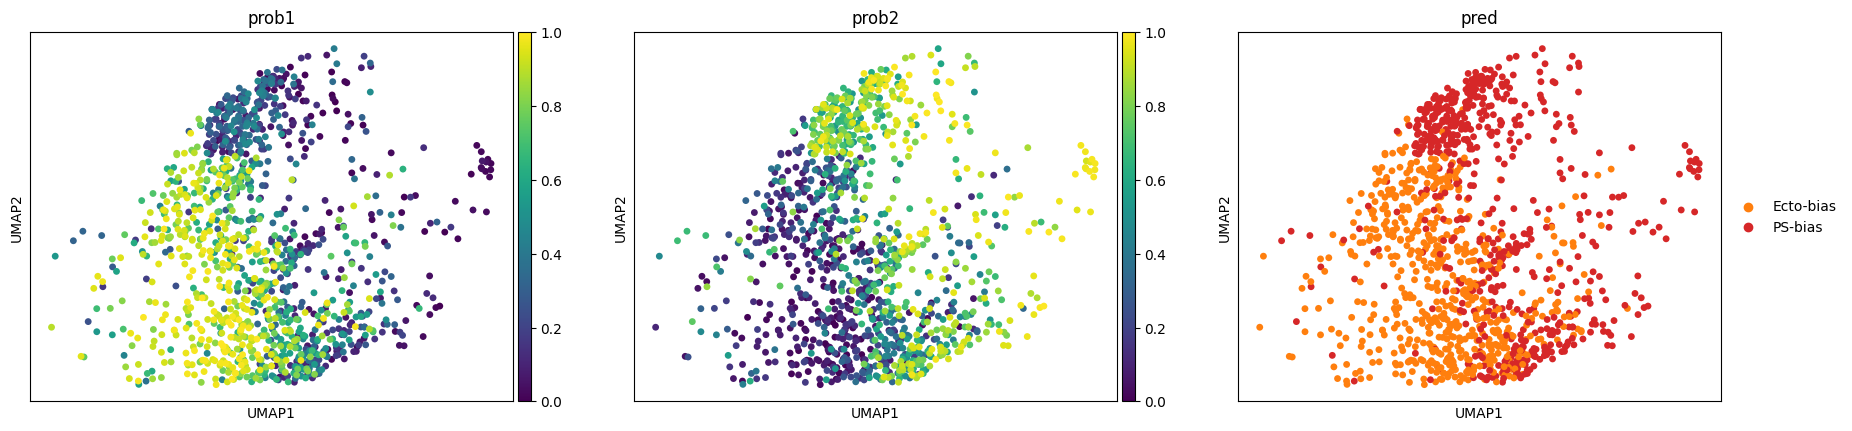

In [30]:
sc.pl.umap(test.adata,color=['prob1','prob2','pred'])

In [19]:
deck.squad

{'logreg_logreg_C_1': <ageas.unit.Unit at 0x7f7af08115e0>,
 'logreg_logreg_C_01': <ageas.unit.Unit at 0x7f7af0811400>,
 'logreg_logreg_C_10': <ageas.unit.Unit at 0x7f7af08101a0>,
 'svc_svc_C_1': <ageas.unit.Unit at 0x7f7af07e3410>,
 'svc_svc_C_10': <ageas.unit.Unit at 0x7f7af07e2f60>,
 'svc_svc_C_01': <ageas.unit.Unit at 0x7f7af07e28d0>,
 'rnn_rnn_latentdim_32_block_dims_[16, 8]_block_num_[2, 2]_block_num_layer2_lr0001_droupout_02': <ageas.unit.Unit at 0x7f7af07e1f10>,
 'rnn_rnn_latentdim_32_block_dims_[16, 8]_block_num_[2, 2]_block_num_layer1_lr001_droupout_01': <ageas.unit.Unit at 0x7f7af07e09e0>,
 'resnet_bottleneck_0': <ageas.unit.Unit at 0x7f7af07dafc0>,
 'resnet_basic_latentdim_32_block_dims_[32, 8]_block_num_[2, 2]_block_num_layer2_lr00001_droupout_02': <ageas.unit.Unit at 0x7f7af07da540>,
 'resnet_basic_latentdim_32_block_dims_[32, 8]_block_num_[2, 2]_block_num_layer2_lr00001_droupout_01': <ageas.unit.Unit at 0x7f7af07d9670>,
 'resnet_basic_latentdim_32_block_dims_[32, 8]_block